In [1]:
import xarray as xr

import numpy as np

import matplotlib.pyplot as plt

The CDR dataset has the area of each grid cell provided as a seperate file, which we need to load

In [2]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"

# Load the observational dataset

The CDR dataset has the area of each grid cell provided as a seperate file, which we need to load

In [3]:
def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds = ds.cdr_conc
    ds = ds.where(ds<=1)  # convert error codes to Nan

    return ds

We can pull the datasets direct from the url, however the cell area needs to be downloaded seperately:

In [4]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


We are interested in the Antarctic, but the lines for the Arctic are below and commented out.

In [5]:
sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat").sel(time=slice("1981","2010"))

nh_cdr_xr = open_cdr_dataset(
    nh_obs_url,
    'psn25area_v3.dat'
).sel(time=slice("1981","2010"))


# And our data

In [6]:
from dask.distributed import Client

In [7]:
client = Client(threads_per_worker = 1)

2025-05-17 12:06:11,389 - distributed.nanny - WARNING - Restarting worker
2025-05-17 12:06:11,464 - distributed.nanny - WARNING - Restarting worker
2025-05-17 12:06:11,467 - distributed.nanny - WARNING - Restarting worker
2025-05-17 12:09:35,922 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:39329' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('open_dataset-hi-concatenate-9c0ce5149101d69ce248fee967a0dbcf', 176, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 70, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 25, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 79, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 54, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 55, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 71, 0, 0), ('concatenate-9c0ce5149101d69ce248fee967a0dbcf', 27, 0, 0), 'original-open_dataset-hi-62be887d58c6d279b8abf5fa7f8e760b', ('concatenate-9c0ce5149101d69c

In [8]:
client

<Client: 'tcp://127.0.0.1:45785' processes=12 threads=12, memory=46.00 GiB>

"Pearce's" CICE4 run from the same ocean restart, uses cice4 with lice changes. (https://forum.access-hive.org.au/t/esm1-6-spin-up-experiments/4219)

In [9]:
ds_cice4 = xr.open_mfdataset('/g/data/tm70/as2285/payu/esm1.6-preind-cice4/archive/output0[0-5][0-9]/ice/HISTORY/iceh.*', compat='override', coords='minimal', parallel=True)

[gadi-cpu-clx-1908:3728286:0:3728286] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x46)
[gadi-cpu-clx-1908:3728279:0:3728279] Caught signal 11 (Segmentation fault: address not mapped to object at address (nil))
[gadi-cpu-clx-1908:3728296:0:3728296] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x48)
BFD: BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwar

In [27]:
ds_cice4.time

<xarray.DataArray 'time' (time: 120)> Size: 960B
array([cftime.DatetimeProlepticGregorian(101, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(102, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(103, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(104, 

In [10]:
def _preproc(ds):
    return ds[['aice','hi', 'tarea']]

In [14]:
ds_noneic = xr.open_mfdataset('/g/data/tm70/as2285/payu/esm1.6-preind-202504-cice5/archive/output*/ice/HISTORY/iceh.06[0-9][0-9]-[0-1][0-9].nc',
                              compat='override', data_vars='minimal',
                    coords='minimal', parallel=True,
                             # preprocess = _preproc
                             )





/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [26]:
ds_noneic.time

<xarray.DataArray 'time' (time: 180)> Size: 1kB
array([cftime.DatetimeProlepticGregorian(685, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(685, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(686, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(687, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(688, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProleptic

Text(0.5, 1.0, 'SH Ice Area')

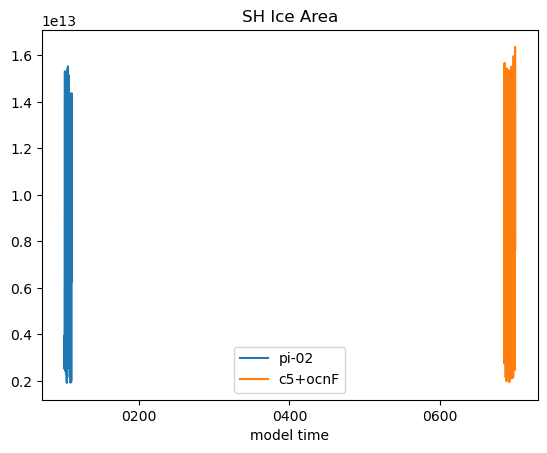

In [15]:
for ids in [ds_cice4, ds_noneic] : #[ds, pi02_ds, ds_cice4, ds_bubbly, ds_noneic]:
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.aice).sel(nj=slice(0,150)).sum(['ni','nj']).plot()

plt.legend(labels=['pi-02','c5+ocnF', 'c4'])
plt.title('SH Ice Area')

Text(0.5, 1.0, 'NH Ice Area')

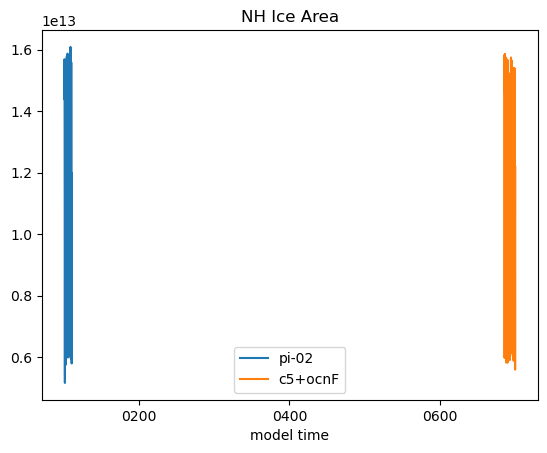

In [16]:
for ids in [ds_cice4, ds_noneic]: #[ds, pi02_ds, ds_cice4, ds_bubbly, ds_noneic]:
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.aice).sel(nj=slice(150,None)).sum(['ni','nj']).plot()

# plt.legend(labels=['cice5-db','pi-02','cice4', 'c5+b+1m_init', 'c5+noneic'])
plt.legend(labels=['pi-02', 'c5+ocnF', 'c5', 'c5_alb'])
plt.title('NH Ice Area')

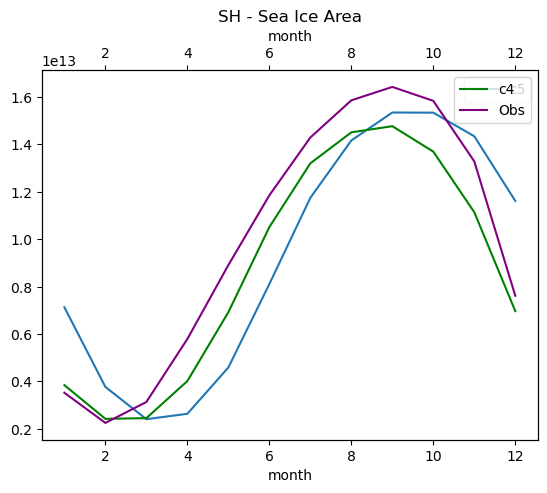

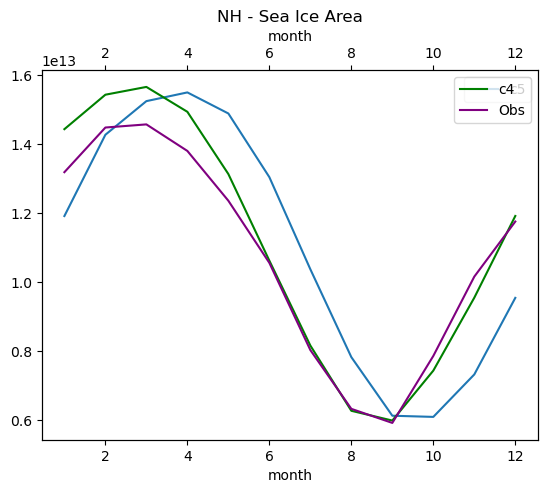

In [20]:
sh = {'slice':slice(0,150), 'name':'SH', 'obs':sh_cdr_xr}
nh = {'slice':slice(150,None), 'name':'NH', 'obs':nh_cdr_xr}

for iHem in [sh,nh]:
    for ids in [ds_noneic]:
        tarea = ids.tarea.load()
        ids.aice.load()
        (tarea*ids.aice).sel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
    
    plt.legend(labels=['c5'])
    
    plt.twiny()
    
    for ids in [ds_cice4]:
        tarea = ids.tarea.load()
        ids.aice.load()
        (tarea*ids.aice).isel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot(c='green')
    
    (iHem['obs']*iHem['obs'].area*1e6).sum(['x','y']).groupby('time.month').mean().plot(c='purple')
    
    plt.title(iHem['name'] + ' - Sea Ice Area')
    plt.legend(labels=['c4', 'Obs'])
    plt.show()

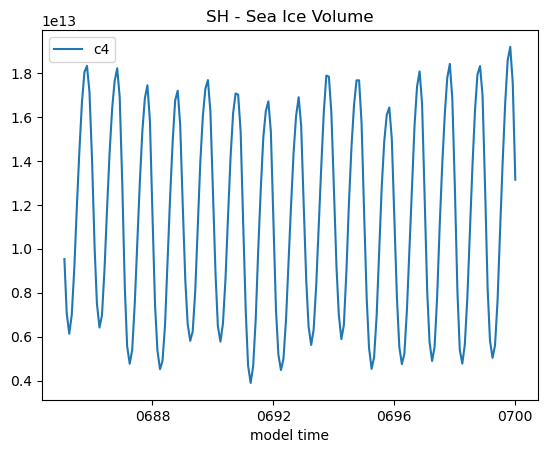

In [23]:
for ids in [ds_noneic]:
    tarea = ids.tarea.load()
    ids.hi.load()
    (tarea*ids.hi).sel(nj=slice(0,150)).sum(['ni','nj']).plot()

plt.title('SH - Sea Ice Volume')
plt.legend(['c4', 'c5+noneic', 'c5'])

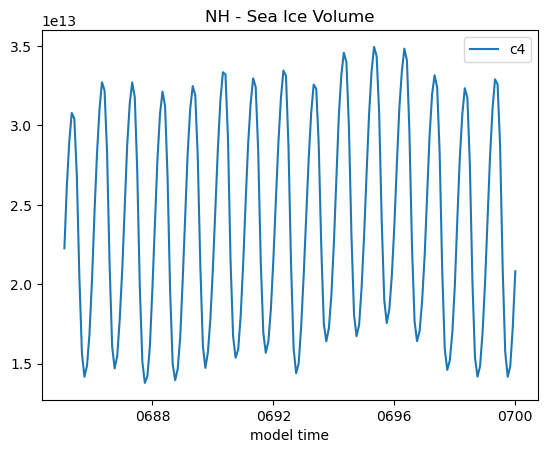

In [24]:
for ids in [ds_noneic]:
    tarea = ids.tarea.load()
    ids.hi.load()
    (tarea*ids.hi).sel(nj=slice(150,None)).sum(['ni','nj']).plot()

plt.title('NH - Sea Ice Volume')
plt.legend(['c4', 'c5+noneic', 'c5'])

In [63]:
pi02_ds.hi.sel(time=slice("0148-01","0148-01"))

<xarray.DataArray 'hi' (time: 1, nj: 300, ni: 360)> Size: 432kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 8B 0148-01-16 12:00:00
    TLON     (nj, ni) float32 432kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float32 432kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    ULON     (nj, ni) float32 432kB -279.0 -278.0 -277.0 ... 80.0 80.0 80.0
    ULAT     (nj, ni) float32 432kB -77.75 -77.75 -77.75 ... 65.83 65.42 65.0
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean ice thickness
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

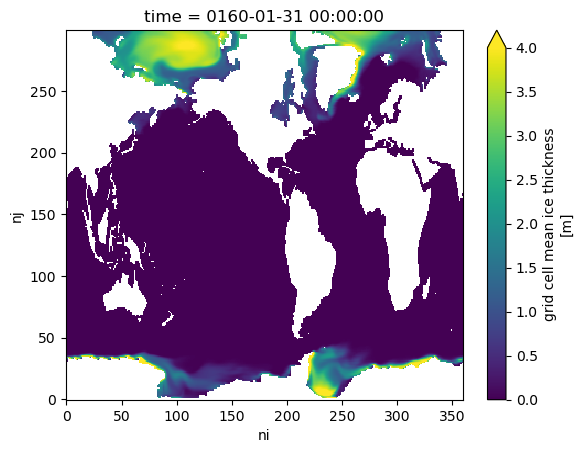

In [34]:
ds_noneic.hi.sel(time=slice("0160-01","0160-01")).plot(vmax=4)

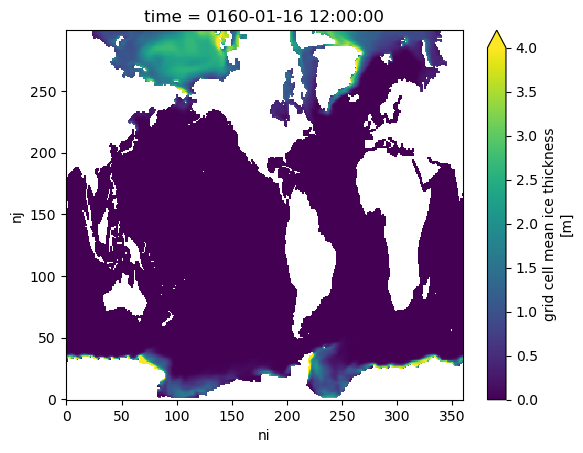

In [35]:
pi02_ds.hi.sel(time=slice("0160-01","0160-01")).plot(vmax=4)

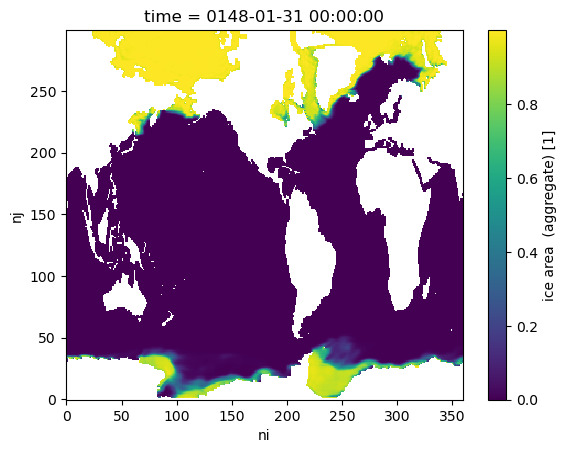

In [72]:
ds_noneic.aice.sel(time=slice("0148-01","0148-01")).plot()

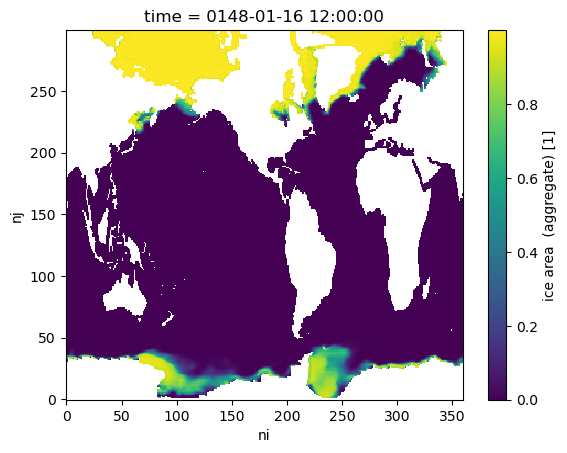

In [58]:
pi02_ds.aice.sel(time=slice("0148-01","0148-01")).plot()

In [24]:
ds_cice4

<xarray.Dataset> Size: 13GB
Dimensions:      (time: 3652, d2: 2, nc: 5, nkice: 1, nksnow: 1, nj: 300,
                  ni: 360)
Coordinates:
  * time         (time) object 29kB 0101-01-01 00:00:00 ... 0110-12-31 00:00:00
    TLON         (nj, ni) float32 432kB 80.5 81.5 82.5 ... 79.96 79.97 79.99
    TLAT         (nj, ni) float32 432kB -77.88 -77.88 -77.88 ... 65.63 65.21
    ULON         (nj, ni) float32 432kB -279.0 -278.0 -277.0 ... 80.0 80.0 80.0
    ULAT         (nj, ni) float32 432kB -77.75 -77.75 -77.75 ... 65.42 65.0
Dimensions without coordinates: d2, nc, nkice, nksnow, nj, ni
Data variables:
    time_bounds  (time, d2) object 58kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    NCAT         (time, nc) float32 73kB dask.array<chunksize=(31, 5), meta=np.ndarray>
    VGRDi        (time, nkice) float32 15kB dask.array<chunksize=(31, 1), meta=np.ndarray>
    VGRDs        (time, nksnow) float32 15kB dask.array<chunksize=(31, 1), meta=np.ndarray>
    tmask        (time, nj, ni) float32 2GB dask.array<chunksize=(31, 300, 360), meta=np.ndarray>
    tarea        (time, nj, ni) float32 2GB 6.41e+08 6.41e+08 ... 3.857e+07
    uarea        (time, nj, ni) float32 2GB dask.array<chunksize=(31, 300, 360), meta=np.ndarray>
    ANGLE        (time, nj, ni) float32 2GB dask.array<chunksize=(31, 300, 360), meta=np.ndarray>
    ANGLET       (time, nj, ni) float32 2GB dask.array<chunksize=(31, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float32 2GB nan nan nan nan ... nan nan nan nan
    hs           (time, nj, ni) float32 2GB dask.array<chunksize=(31, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float32 2GB dask.array<chunksize=(31, 300, 360), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       sea ice model: Community Ice Code (AusCOM/CICE4.1)
    comment:      This Year Has 365 days
    comment2:     File written on model date 01010102
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2025-04-15 at 11:15:51.3

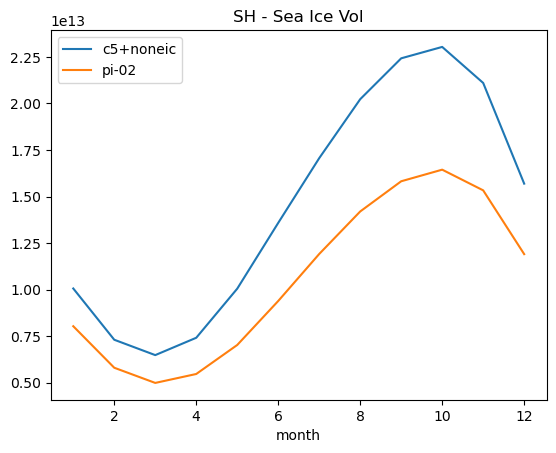

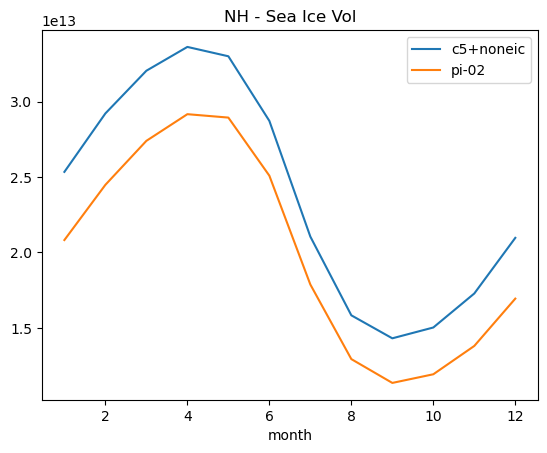

In [44]:
sh = {'slice':slice(0,150), 'name':'SH'}
nh = {'slice':slice(150,None), 'name':'NH'}

for iHem in [sh,nh]:
    for ids in [ds_noneic]:
        tarea = ids.tarea.load()
        ids.hi.load()
        (tarea*ids.hi).sel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
    
    # plt.legend(labels=['c5+noneic'])
    
    # plt.twiny()
    
    for ids in [pi02_ds]:
        tarea = ids.tarea.load()
        ids.hi.load()
        (tarea*ids.hi).isel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
        
    plt.title(iHem['name'] + ' - Sea Ice Vol')
    plt.legend(labels=['c5+noneic', 'pi-02', 'cice4'])
    plt.show()

In [17]:
ocn_scalar_ds = xr.open_mfdataset(
    '/g/data/tm70/as2285/payu/esm1.6-preind+c-cice5+om2_ic/archive/output0*/ocean/ocean-scalar-1monthly-ym_0*.nc'
)

ocn_scalar_ds

ocn_scalar_ds.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

<xarray.Dataset> Size: 190kB
Dimensions:                      (time: 1188, scalar_axis: 1, nv: 2)
Coordinates:
  * scalar_axis                  (scalar_axis) float64 8B 0.0
  * time                         (time) object 10kB 0101-01-15 12:00:00 ... 0...
  * nv                           (nv) float64 16B 1.0 2.0
Data variables: (12/32)
    total_mass_seawater          (time, scalar_axis) float32 5kB 1.335e+21 .....
    total_volume_seawater        (time, scalar_axis) float32 5kB 1.29e+18 ......
    eta_global                   (time, scalar_axis) float32 5kB -3.836 ... -...
    eta_adjust                   (time, scalar_axis) float32 5kB 2.003e-06 .....
    pbot_adjust                  (time, scalar_axis) float32 5kB 2.036e-06 .....
    temp_global_ave              (time, scalar_axis) float32 5kB 4.278 ... 4.254
    ...                           ...
    temp_surface_ave             (time, scalar_axis) float32 5kB 18.96 ... 17.82
    salt_surface_ave             (time, scalar_axis) float32 5kB 34.61 ... 34.53
    average_T1                   (time) object 10kB 0100-12-31 00:00:00 ... 0...
    average_T2                   (time) object 10kB 0101-01-31 00:00:00 ... 0...
    average_DT                   (time) timedelta64[ns] 10kB 31 days ... 31 days
    time_bnds                    (time, nv) timedelta64[ns] 19kB 36524 days ....
Attributes:
    filename:   ocean-scalar-1monthly-ym_0101_01.nc
    title:      ACCESS-ESM_CMIP6
    grid_type:  regular
    grid_tile:  N/A

In [18]:
ocn_sal_ds = xr.open_mfdataset(
    '/g/data/tm70/as2285/payu/esm1.6-preind+c-cice5+sal4/archive/output0*/ocean/ocean-scalar-1monthly-ym_0*.nc'
)

ocn_lprec0_ds.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


<xarray.Dataset> Size: 2kB
Dimensions:                      (scalar_axis: 1, time: 12, nv: 2)
Coordinates:
  * scalar_axis                  (scalar_axis) float64 8B 0.0
  * time                         (time) object 96B 0113-01-15 12:00:00 ... 01...
  * nv                           (nv) float64 16B 1.0 2.0
Data variables: (12/32)
    total_mass_seawater          (time, scalar_axis) float32 48B 1.335e+21 .....
    total_volume_seawater        (time, scalar_axis) float32 48B 1.29e+18 ......
    eta_global                   (time, scalar_axis) float32 48B -3.598 ... -...
    eta_adjust                   (time, scalar_axis) float32 48B 2.029e-06 .....
    pbot_adjust                  (time, scalar_axis) float32 48B 2.063e-06 .....
    temp_global_ave              (time, scalar_axis) float32 48B 4.274 ... 4.271
    ...                           ...
    temp_surface_ave             (time, scalar_axis) float32 48B 18.82 ... 18.32
    salt_surface_ave             (time, scalar_axis) float32 48B 34.56 ... 34.57
    average_T1                   (time) object 96B 0112-12-31 00:00:00 ... 01...
    average_T2                   (time) object 96B 0113-01-31 00:00:00 ... 01...
    average_DT                   (time) timedelta64[ns] 96B 31 days ... 31 days
    time_bnds                    (time, nv) timedelta64[ns] 192B 40907 days ....
Attributes:
    filename:   ocean-scalar-1monthly-ym_0113_01.nc
    title:      ACCESS-ESM_CMIP6
    grid_type:  regular
    grid_tile:  N/A

In [ ]:
c4_scalar_ds = xr.open_mfdataset(
    '/scratch/p66/pjb581/access-esm/archive/pi_concentrations-expt-c55f7217/output0*/ocean/ocean-scalar-1monthly-ym_0*.nc'
)

c4_scalar_ds.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [ ]:
ocn_scalar_ds.sel(time=slice("0100","0120")).total_mass_seawater.plot()
c4_scalar_ds.sel(time=slice("0100","0120")).total_mass_seawater.plot()
ocn_lprec0_ds.sel(time=slice("0100","0120")).total_mass_seawater.plot()
# c4_scalar_ds2.total_mass_seawater.plot()
plt.legend(['cice5','cice4-pearce', 'lprec0'])


In [20]:
.1*1e17

1e+16

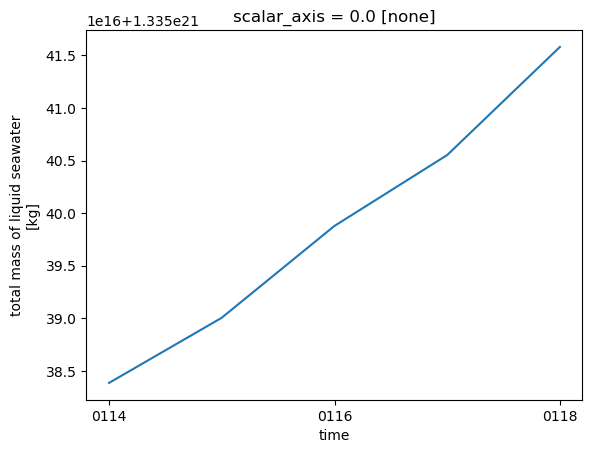

In [25]:
ocn_lprec0_ds.total_mass_seawater.resample({'time':'YE'}).mean().plot()

In [26]:
1e16 / (365*24*60*60)

317097919.8376459

In [28]:
317097919 / 0.18543417E+08

17.100295970262653

In [13]:
list(ocn_scalar_ds.data_vars)

['total_mass_seawater',
 'total_volume_seawater',
 'eta_global',
 'eta_adjust',
 'pbot_adjust',
 'temp_global_ave',
 'salt_global_ave',
 'total_ocean_pme_river',
 'total_ocean_river',
 'total_ocean_evap',
 'total_ocean_pme_sbc',
 'total_ocean_fprec',
 'total_ocean_lprec',
 'total_ocean_runoff',
 'total_ocean_salt',
 'total_ocean_heat',
 'total_ocean_hflux_pme',
 'total_ocean_swflx',
 'total_ocean_swflx_vis',
 'total_ocean_evap_heat',
 'total_ocean_lw_heat',
 'total_ocean_sens_heat',
 'total_ocean_fprec_melt_heat',
 'total_ocean_runoff_heat',
 'ke_tot',
 'pe_tot',
 'temp_surface_ave',
 'salt_surface_ave',
 'average_T1',
 'average_T2',
 'average_DT',
 'time_bnds']

In [24]:
ds_lprec0

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 60, d2: 2, nkice: 1, nksnow: 1, nkbio: 2, nj: 300,
                   ni: 360, nc: 5)
Coordinates:
  * time          (time) object 480B 0113-01-31 00:00:00 ... 0117-12-31 00:00:00
    TLON          (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLAT          (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ULON          (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ULAT          (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    NCAT          (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: d2, nkice, nksnow, nkbio, nj, ni, nc
Data variables: (12/66)
    time_bounds   (time, d2) object 960B dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDi         (nkice) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    VGRDs         (nksnow) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    VGRDb         (nkbio) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    tmask         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    blkmask       (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ...            ...
    aicen         (time, nc, nj, ni) float32 130MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    vicen         (time, nc, nj, ni) float32 130MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    fsurfn_ai     (time, nc, nj, ni) float32 130MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    fcondtopn_ai  (time, nc, nj, ni) float32 130MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    fmelttn_ai    (time, nc, nj, ni) float32 130MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    flatn_ai      (time, nc, nj, ni) float32 130MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This year has 365 days
    comment2:     File written on model date 01130201
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2025-05-02 at 09:40:30.2
    io_flavor:    io_netcdf

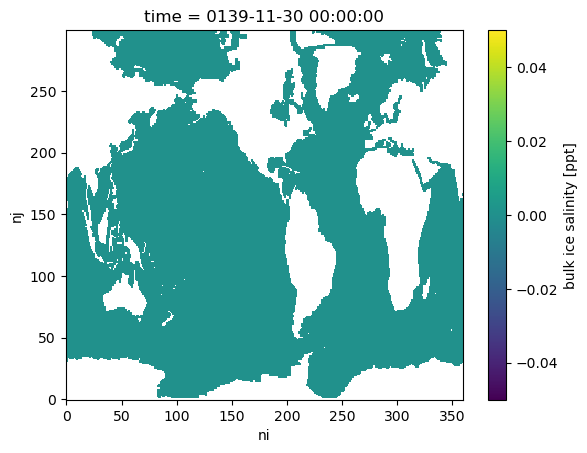

In [30]:
ds_noneic.sice.isel(time=-2).plot()

In [67]:
ds_cice4

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 120, d2: 2, nkice: 1, nksnow: 1, nj: 300, ni: 360,
                   nc: 5)
Coordinates:
  * time          (time) object 960B 0101-01-16 12:00:00 ... 0110-12-16 12:00:00
    TLON          (nj, ni) float32 432kB 80.5 81.5 82.5 ... 79.96 79.97 79.99
    TLAT          (nj, ni) float32 432kB -77.88 -77.88 -77.88 ... 65.63 65.21
    ULON          (nj, ni) float32 432kB -279.0 -278.0 -277.0 ... 80.0 80.0 80.0
    ULAT          (nj, ni) float32 432kB -77.75 -77.75 -77.75 ... 65.42 65.0
    NCAT          (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: d2, nkice, nksnow, nj, ni, nc
Data variables: (12/55)
    time_bounds   (time, d2) object 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDi         (time, nkice) float32 480B dask.array<chunksize=(1, 1), meta=np.ndarray>
    VGRDs         (time, nksnow) float32 480B dask.array<chunksize=(1, 1), meta=np.ndarray>
    tmask         (time, nj, ni) float32 52MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea         (time, nj, ni) float32 52MB 6.41e+08 6.41e+08 ... 3.857e+07
    uarea         (time, nj, ni) float32 52MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ...            ...
    aicen         (time, nc, nj, ni) float32 259MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    vicen         (time, nc, nj, ni) float32 259MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    fsurfn_ai     (time, nc, nj, ni) float32 259MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    fcondtopn_ai  (time, nc, nj, ni) float32 259MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    fmelttn_ai    (time, nc, nj, ni) float32 259MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
    flatn_ai      (time, nc, nj, ni) float32 259MB dask.array<chunksize=(1, 5, 300, 360), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       sea ice model: Community Ice Code (AusCOM/CICE4.1)
    comment:      This Year Has 365 days
    comment2:     File written on model date 01010201
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2025-04-15 at 11:22:17.7

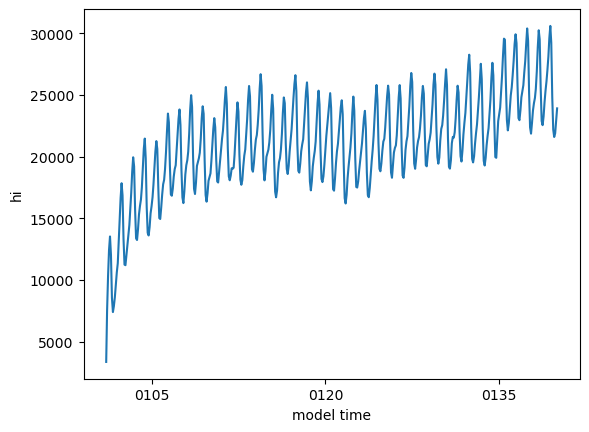

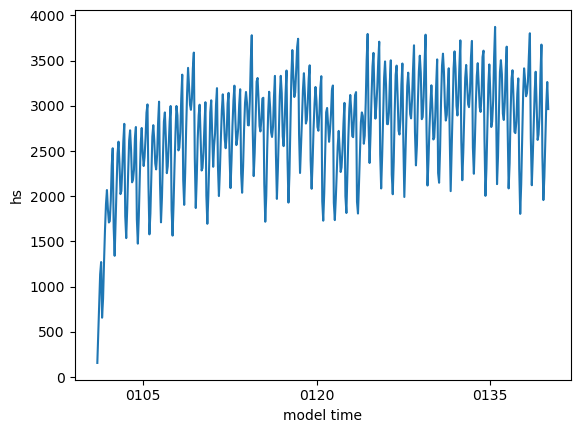

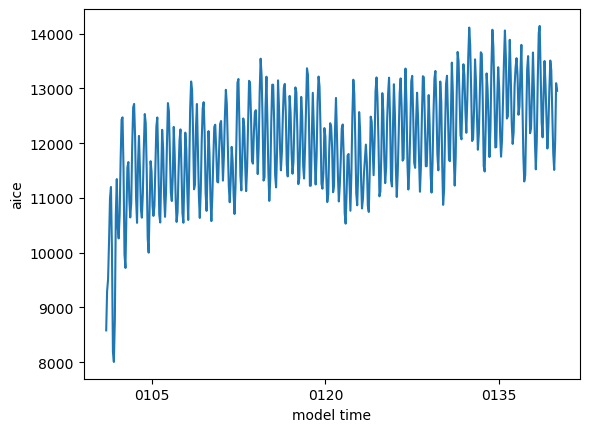

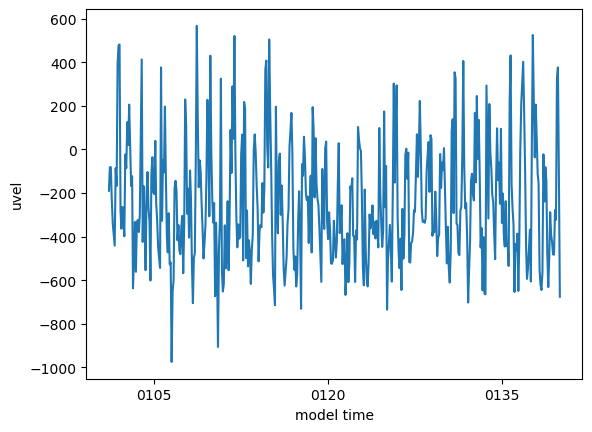

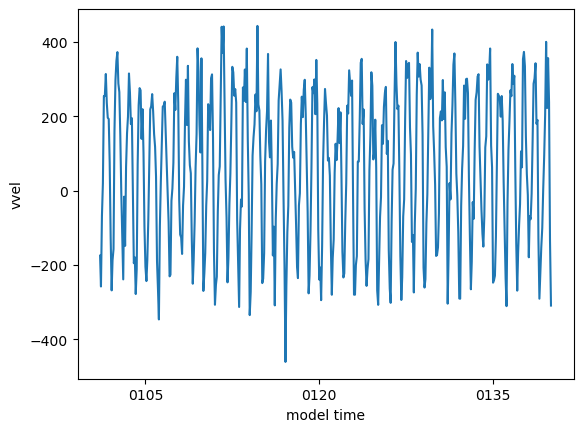

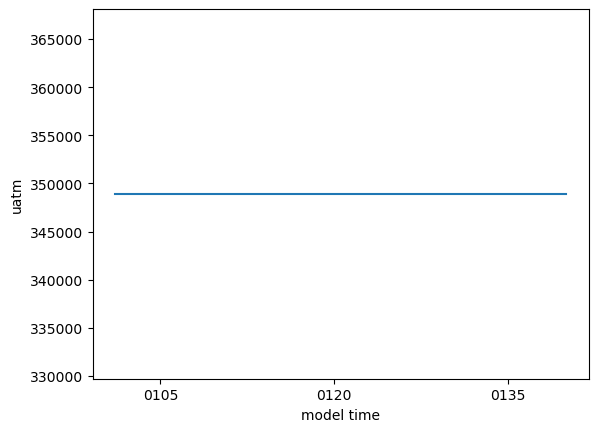

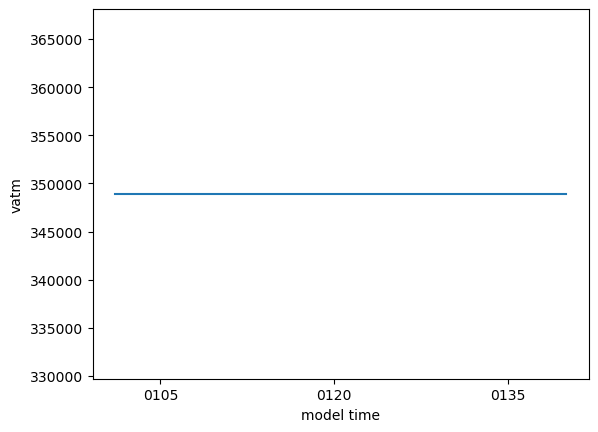

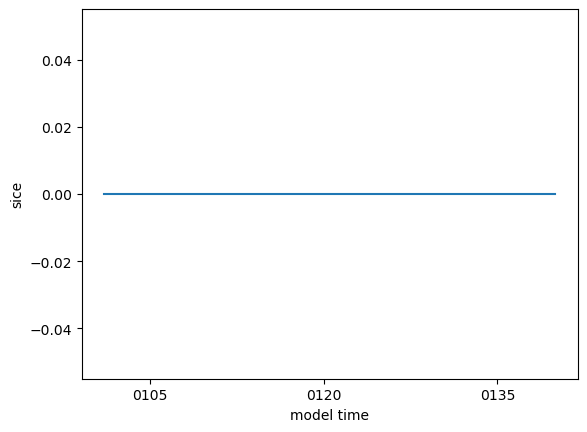

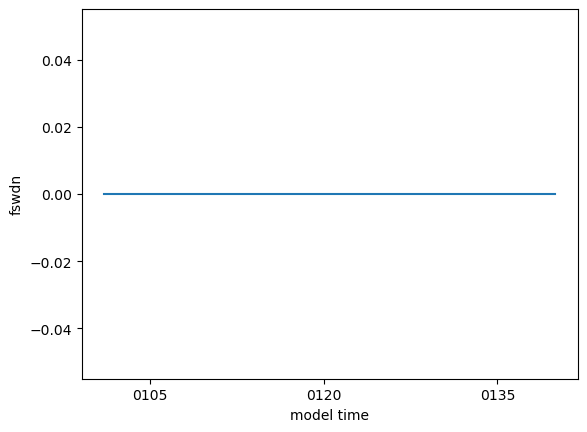

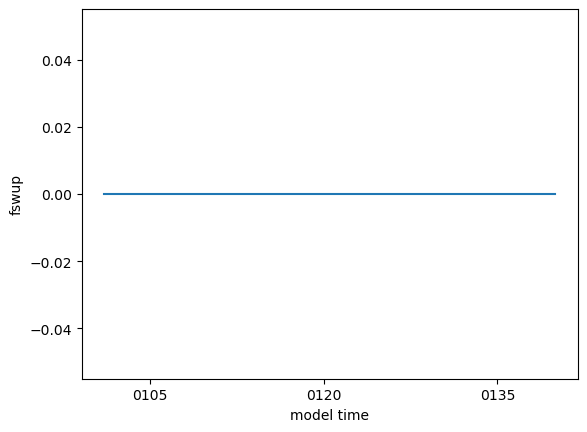

[gadi-cpu-clx-2733:315404:0:315540] Caught signal 11 (Segmentation fault: invalid permissions for mapped object at address 0x14f42c8e3ff8)
==== backtrace (tid: 315540) ====
 0 0x0000000000012d10 __funlockfile()  :0
 1 0x00000000000937ec __GI__IO_default_xsputn()  :0
 2 0x000000000006653b _IO_vfprintf_internal()  :0
 3 0x000000000008e64d _IO_vasprintf()  :0
 4 0x00000000000f2552 H5E_printf_stack()  ???:0
 5 0x0000000000193199 H5I_inc_ref()  ???:0
 6 0x00000000000f23e7 H5E__push_stack()  ???:0
 7 0x00000000000f2577 H5E_printf_stack()  ???:0
 8 0x0000000000193199 H5I_inc_ref()  ???:0
 9 0x00000000000f23e7 H5E__push_stack()  ???:0
10 0x00000000000f2577 H5E_printf_stack()  ???:0
11 0x0000000000193199 H5I_inc_ref()  ???:0
12 0x00000000000f23e7 H5E__push_stack()  ???:0
13 0x00000000000f2577 H5E_printf_stack()  ???:0
14 0x0000000000193199 H5I_inc_ref()  ???:0
15 0x00000000000f23e7 H5E__push_stack()  ???:0
16 0x00000000000f2577 H5E_printf_stack()  ???:0
17 0x0000000000193199 H5I_inc_ref()  ???:

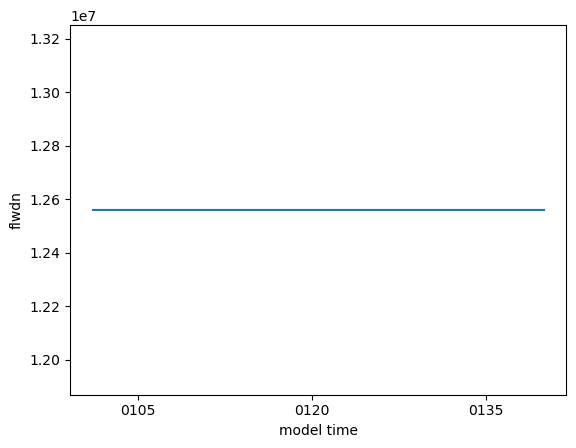

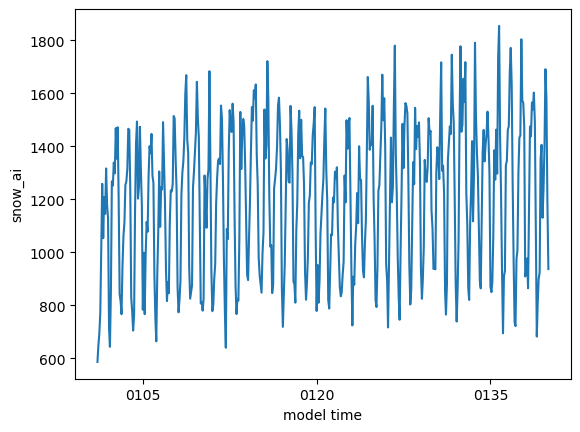

[gadi-cpu-clx-2733:315381:0:315381] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x150)
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges sect

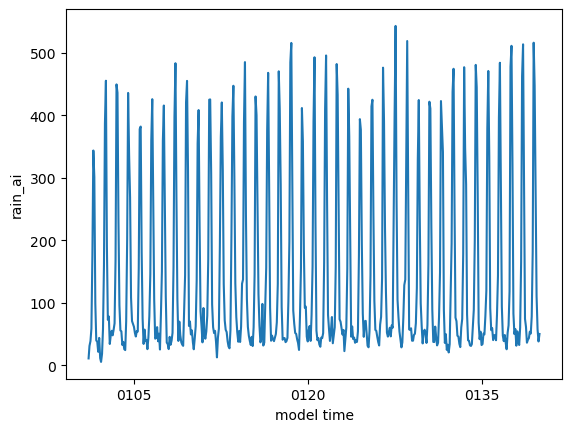

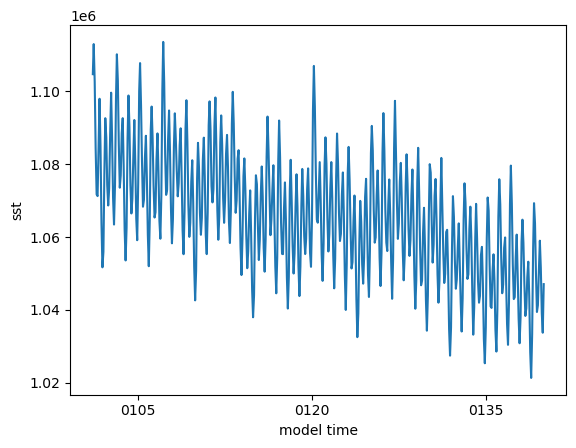

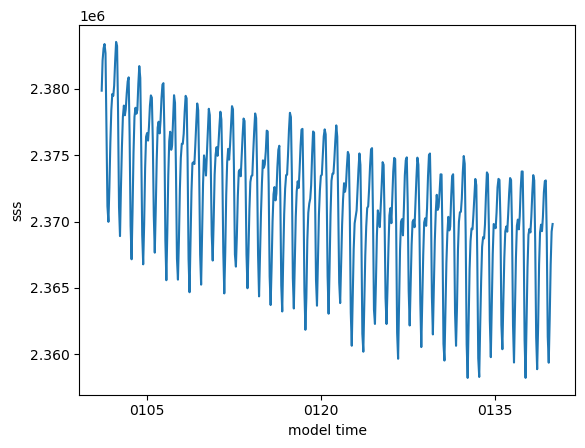

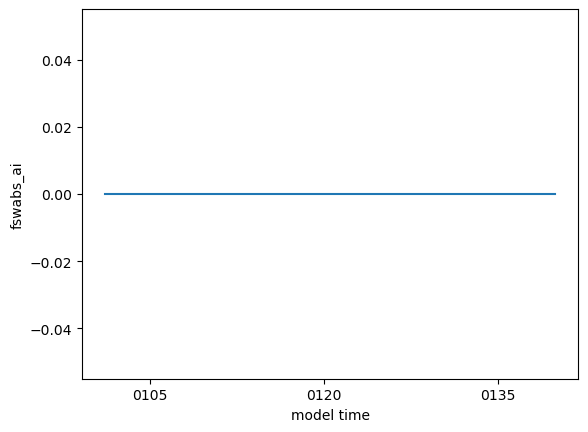

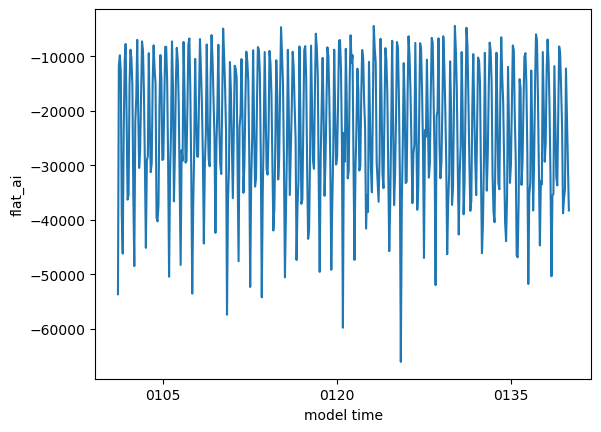

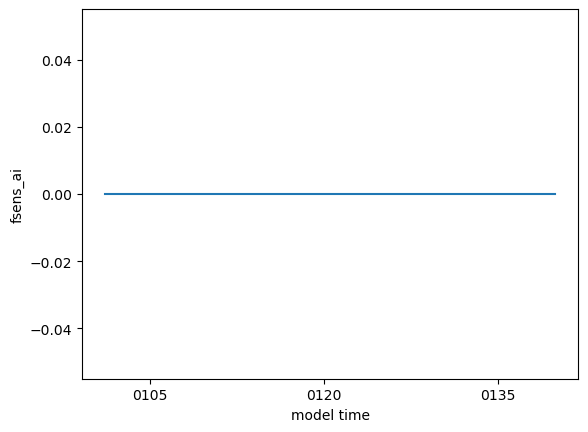

[gadi-cpu-clx-2733:315372:0:315372] Caught signal 11 (Segmentation fault: Sent by the kernel at address (nil))
free(): invalid size


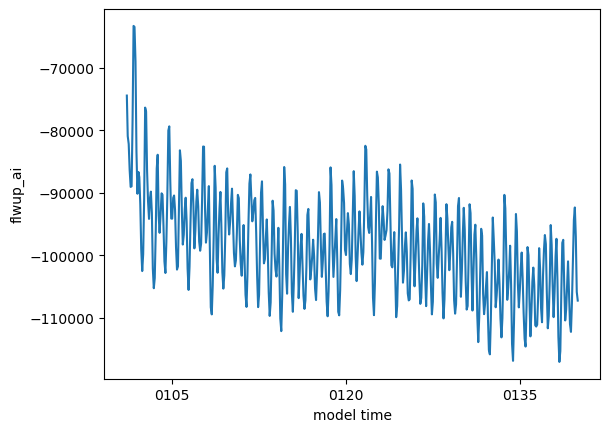

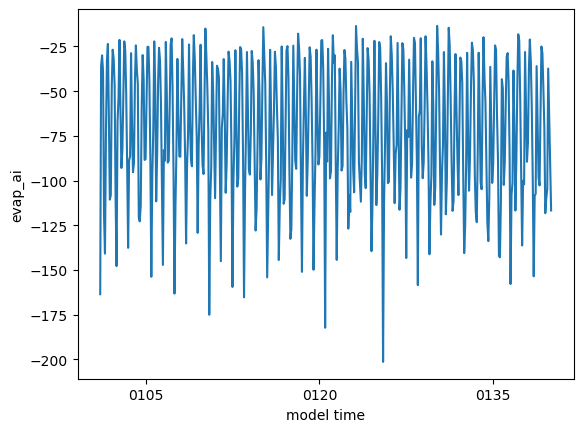

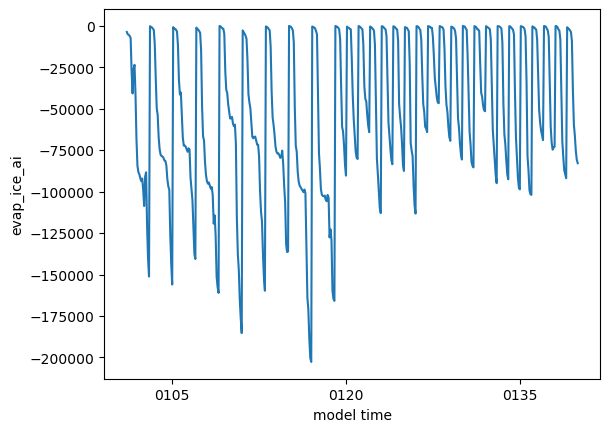

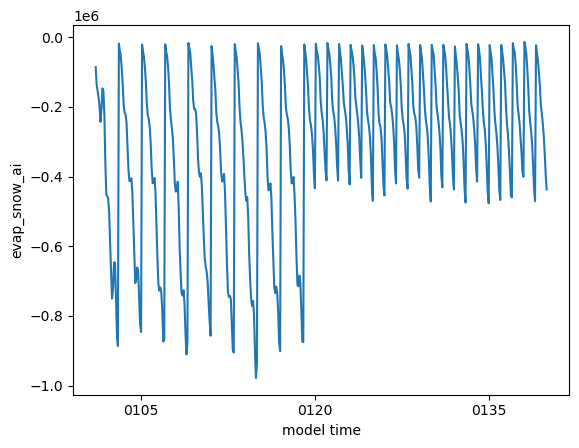

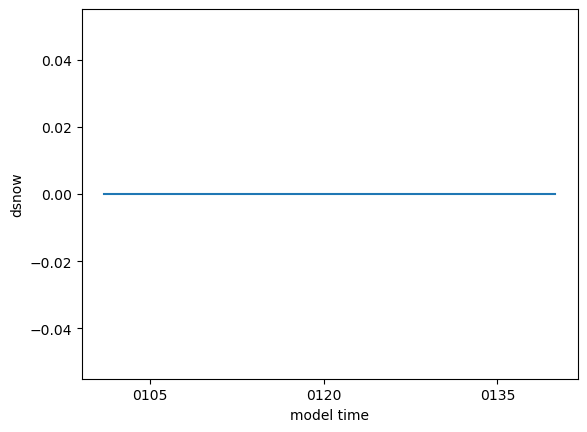

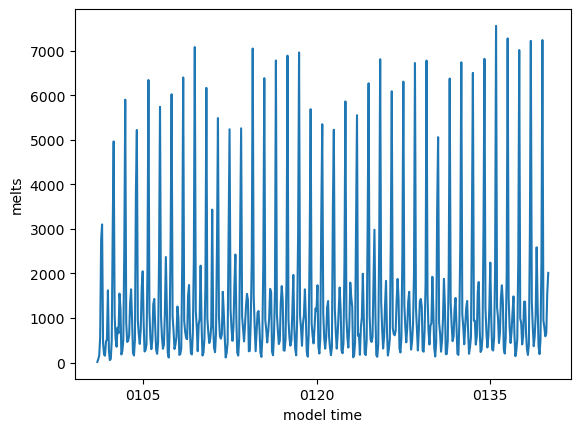

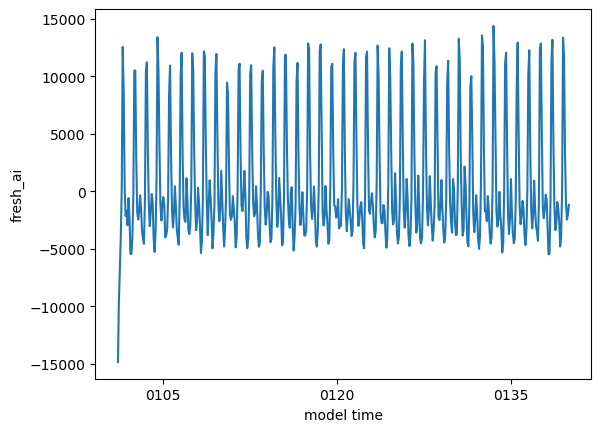

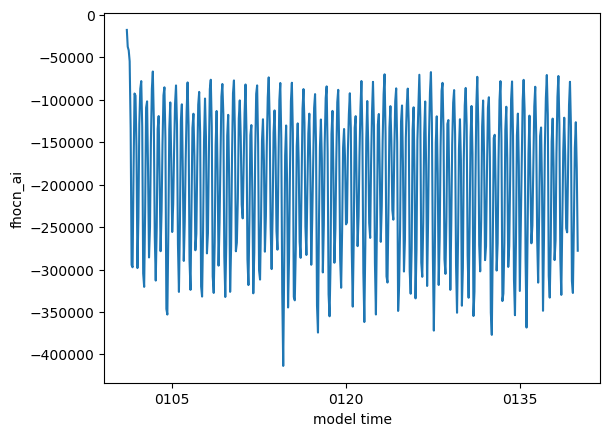

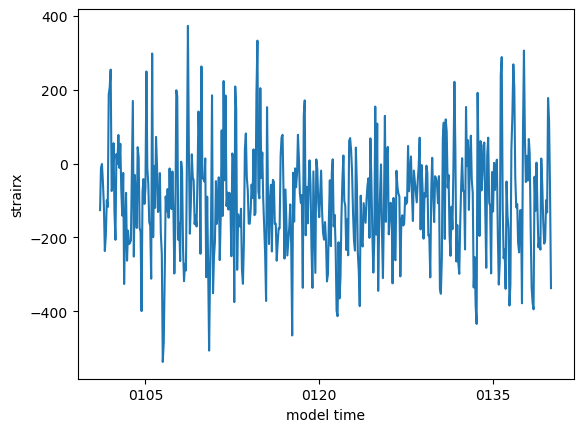

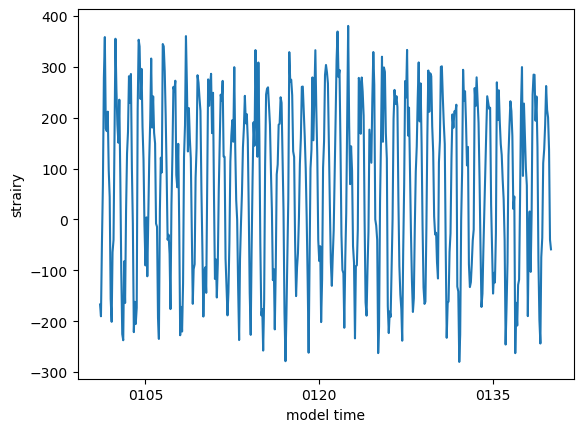

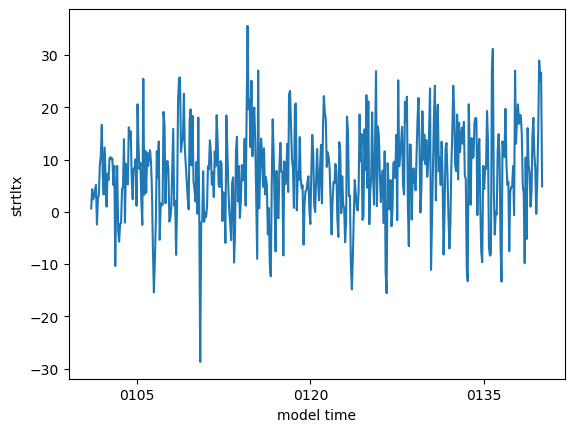

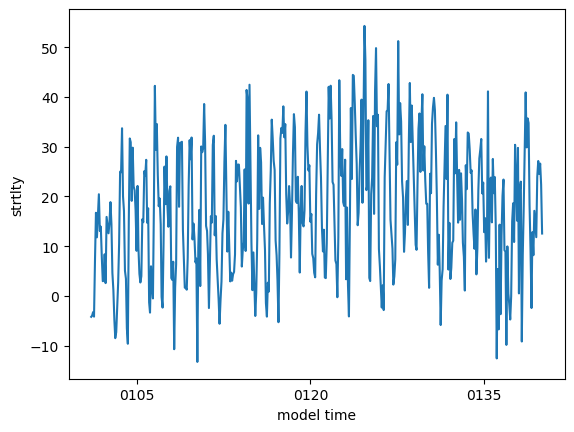

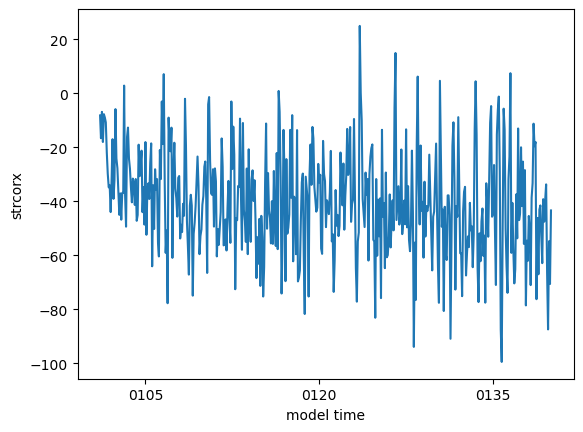

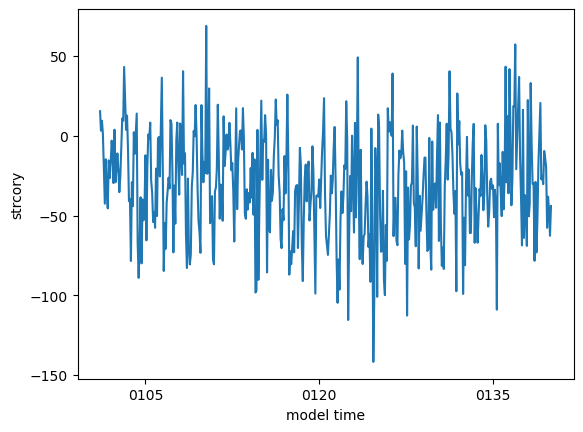

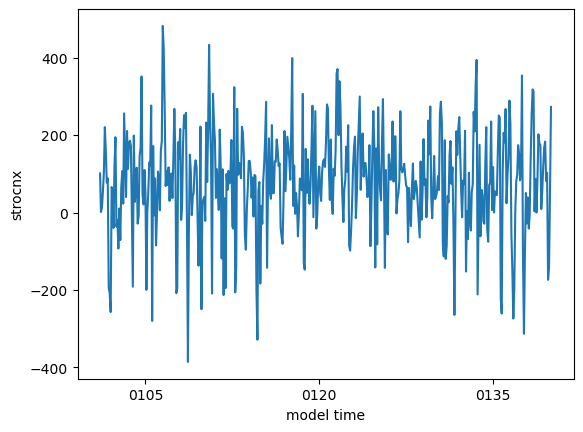

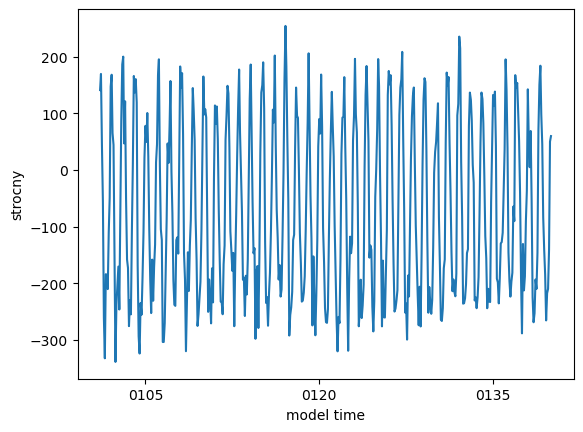

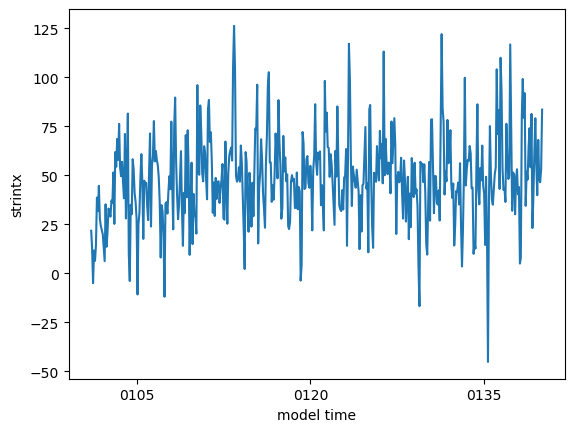

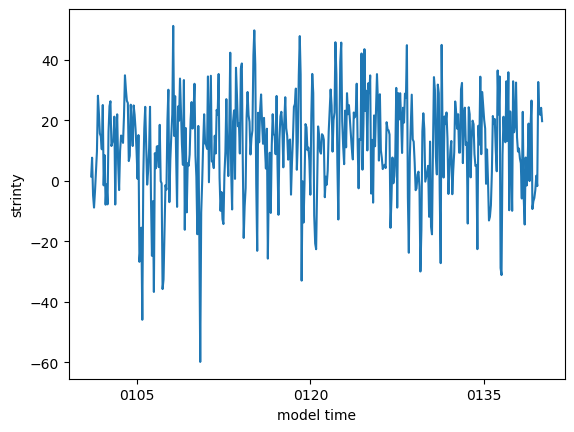

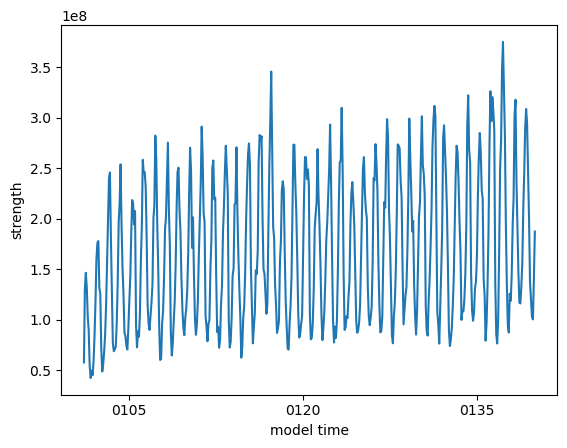

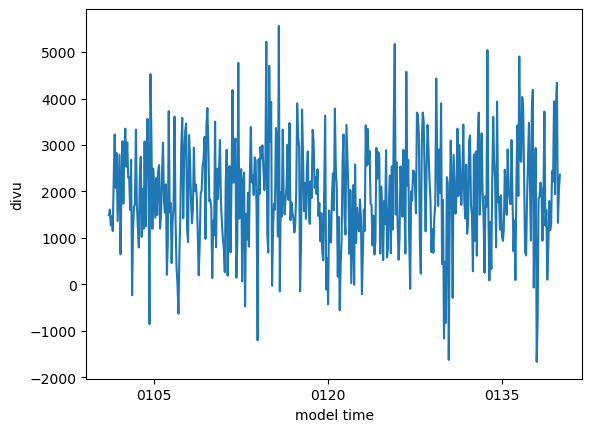

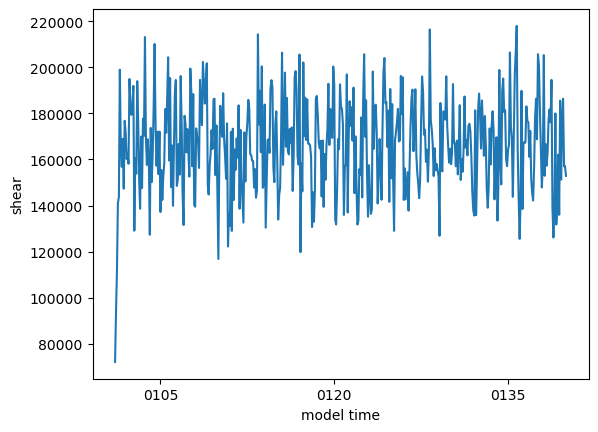

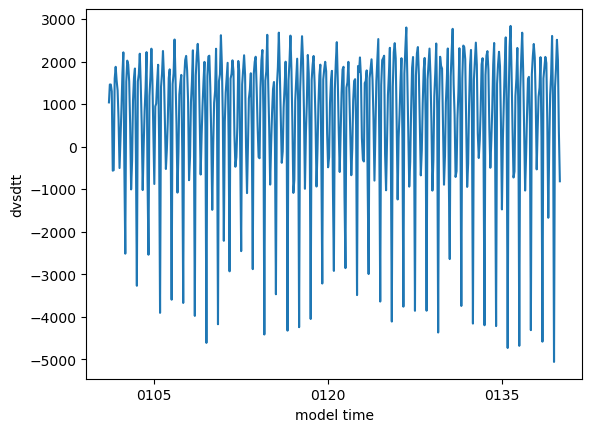

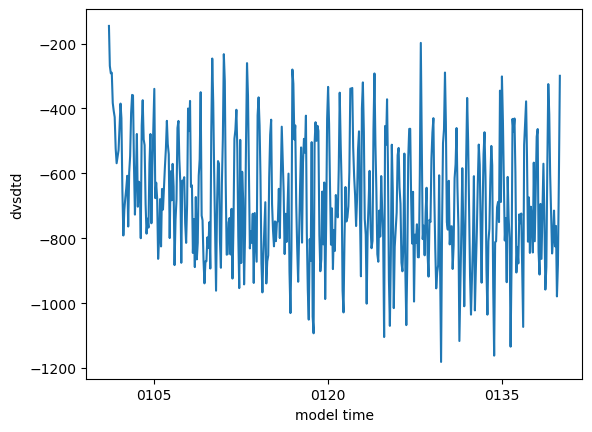

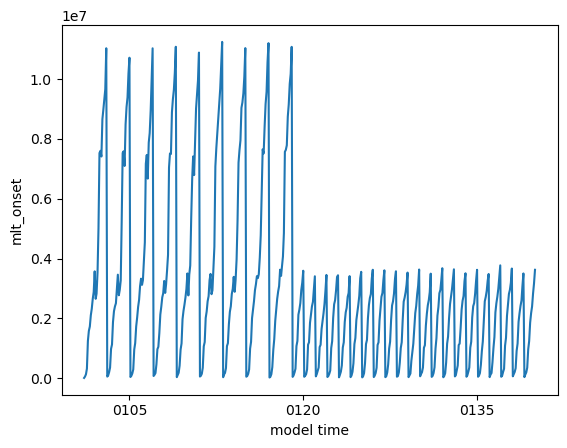

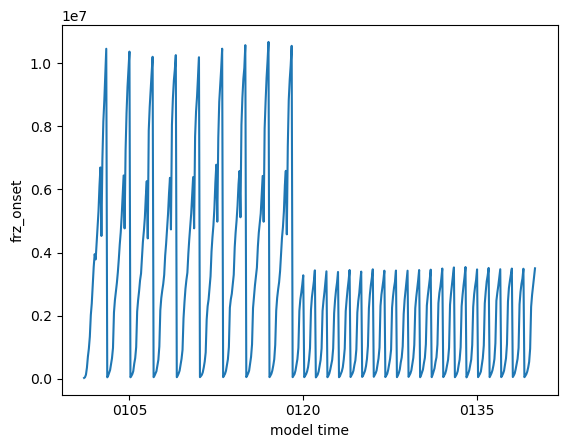

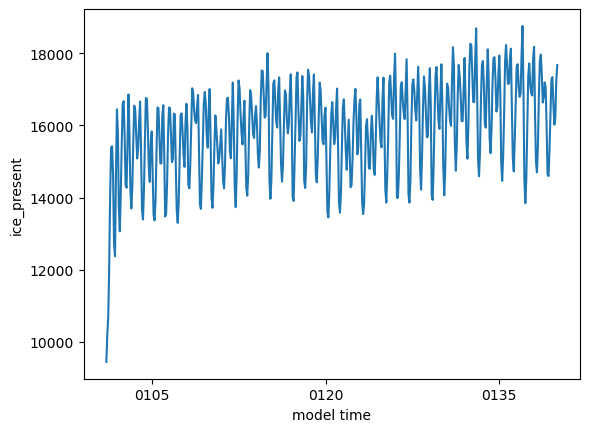

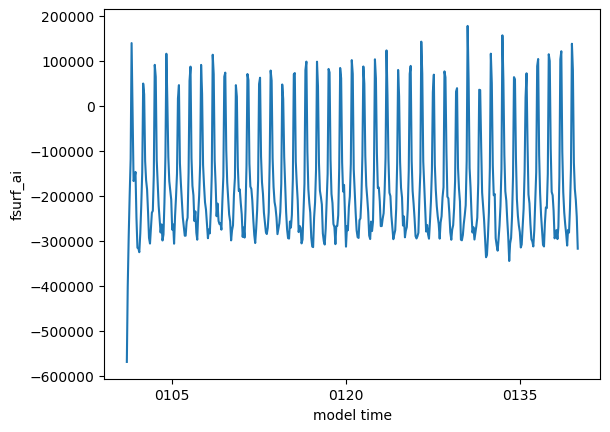

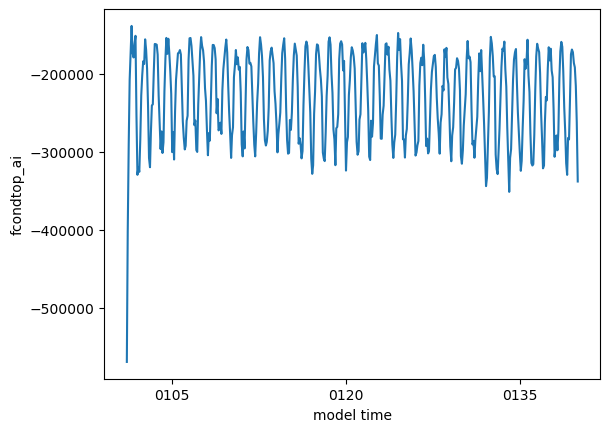

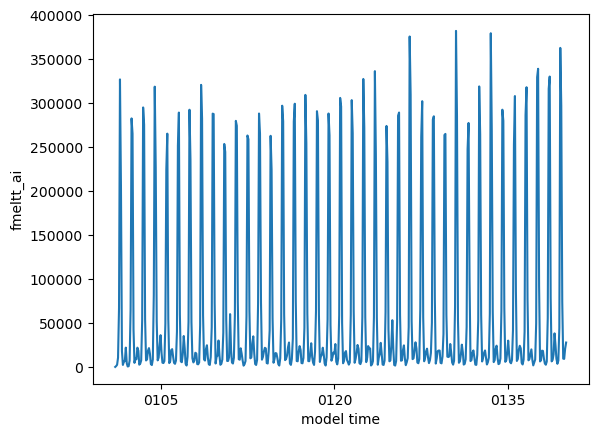

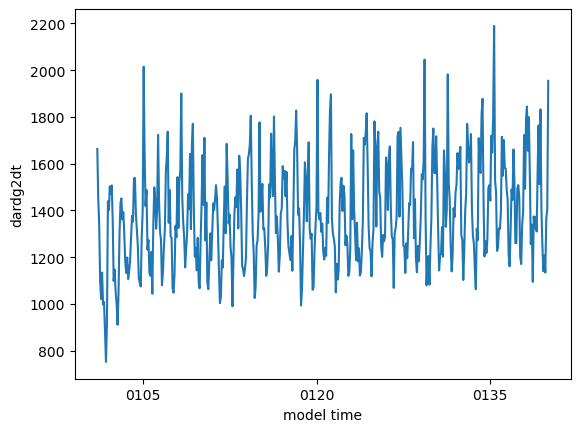

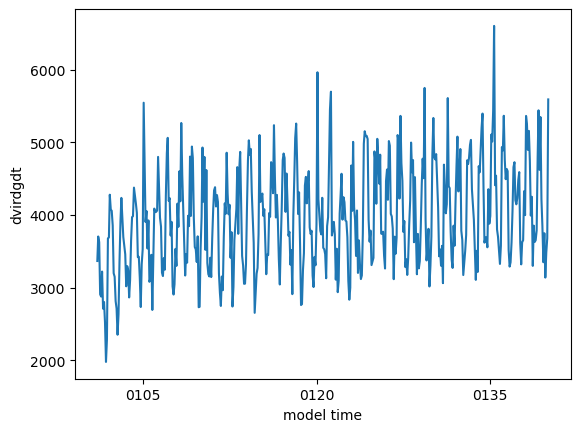

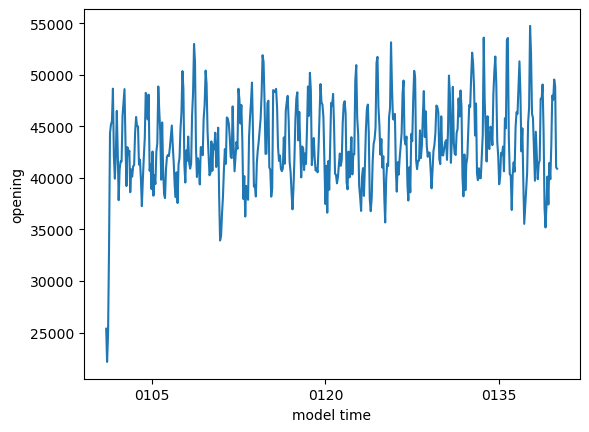

2025-05-05 13:38:53,160 - distributed.client - WARNING - Couldn't gather 19 keys, rescheduling (('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 412, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 396, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 339, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 77, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 358, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 380, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 432, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 315, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 394, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 337, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 378, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 411, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 54, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 52, 0), ('sum-aggregate-34da825de597d944de92f6cd4ff2b826', 82, 0), ('sum-ag

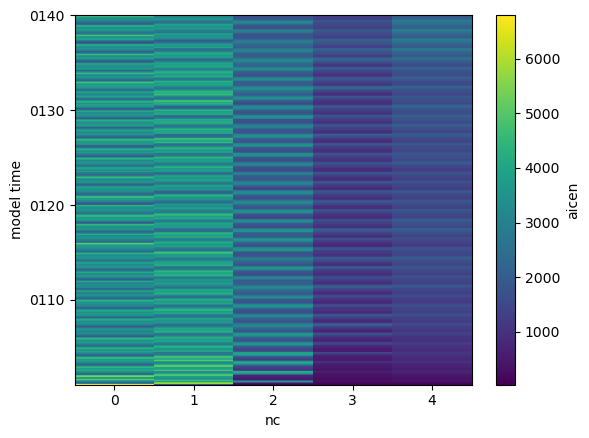

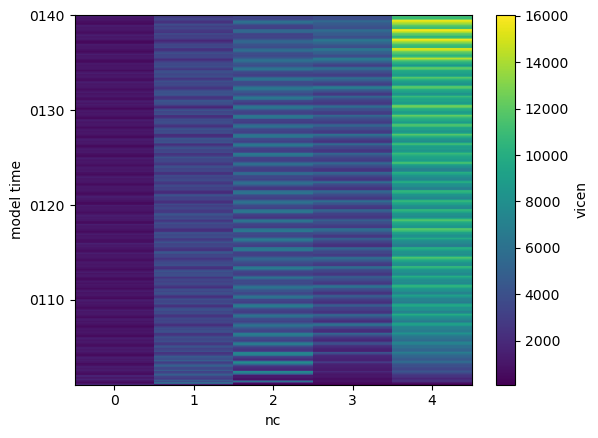

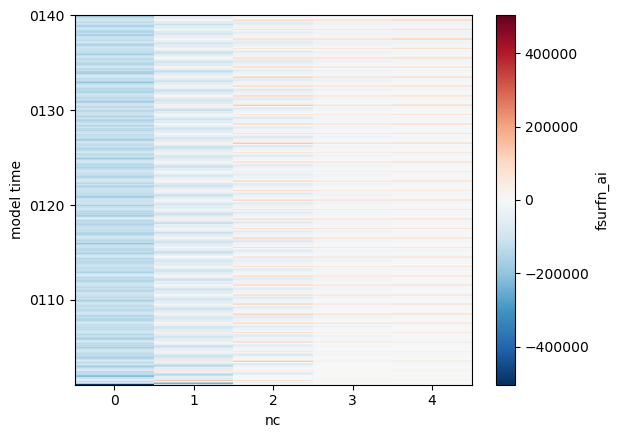

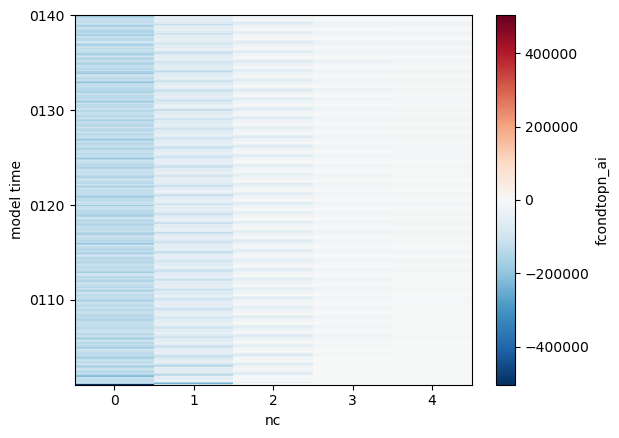

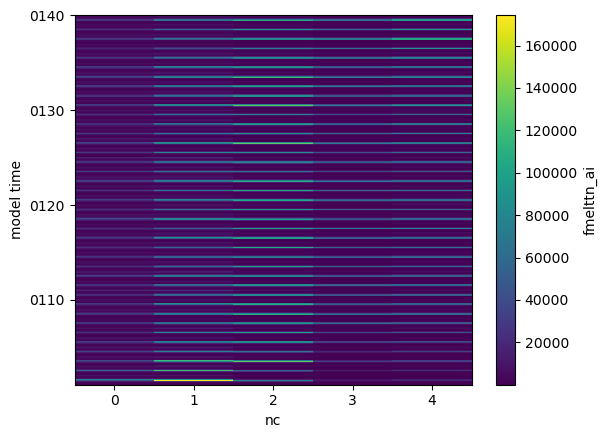

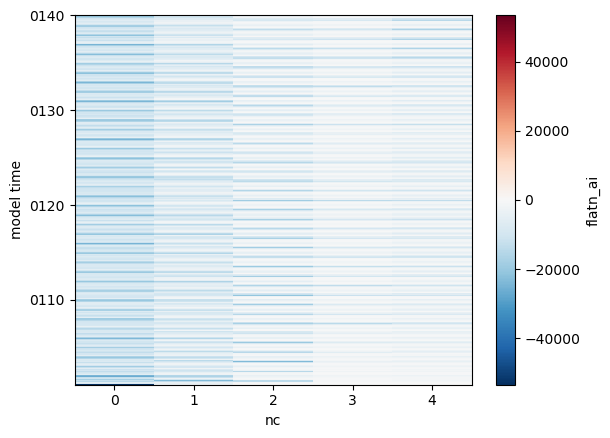

In [28]:
for iVar in list(ds_noneic.data_vars)[10:]:
    ds_noneic[iVar].sum(['ni','nj']).plot()
    plt.show()

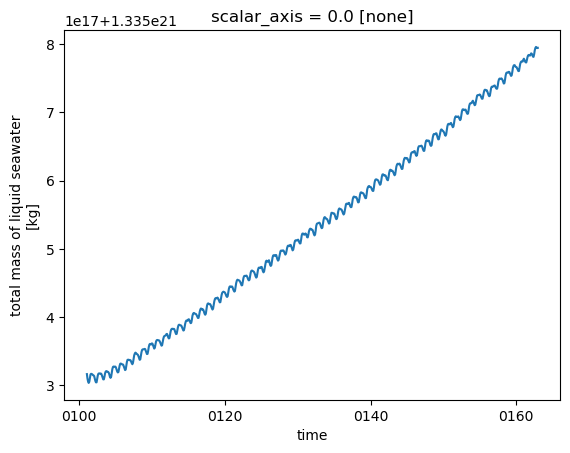

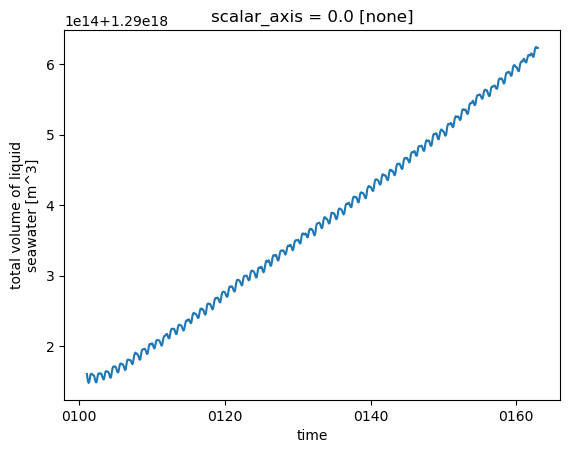

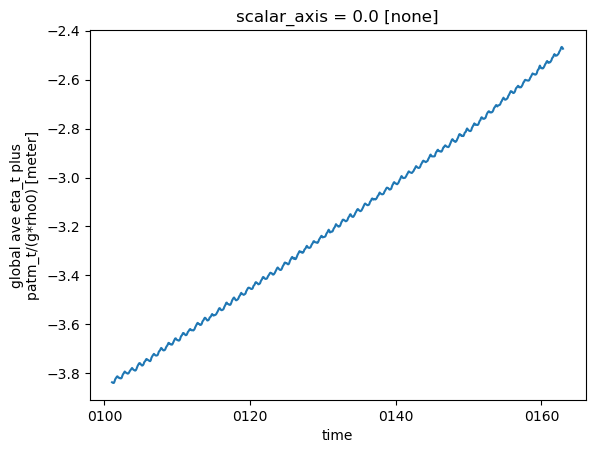

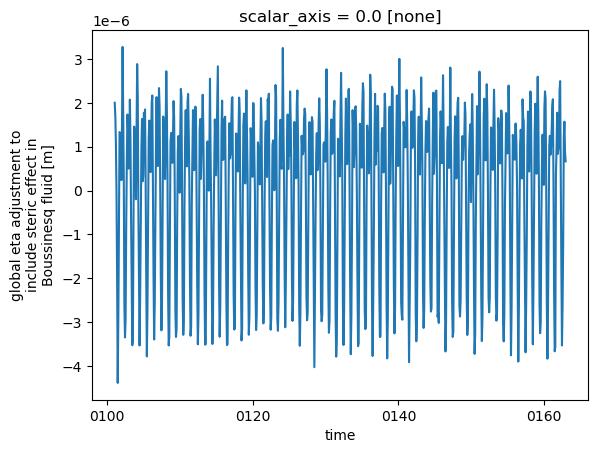

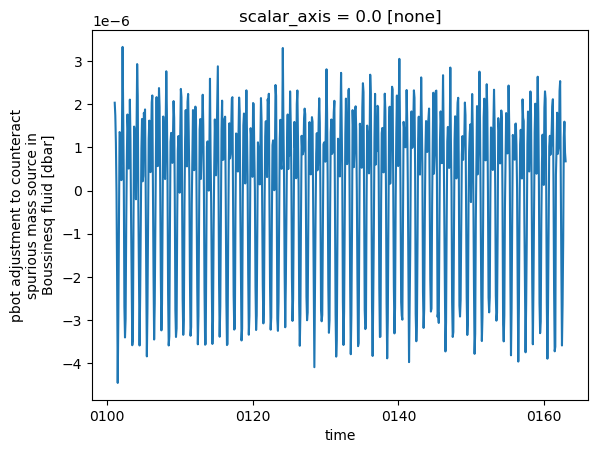

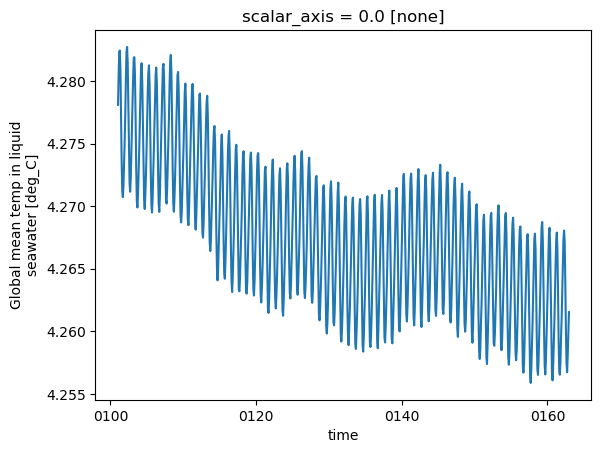

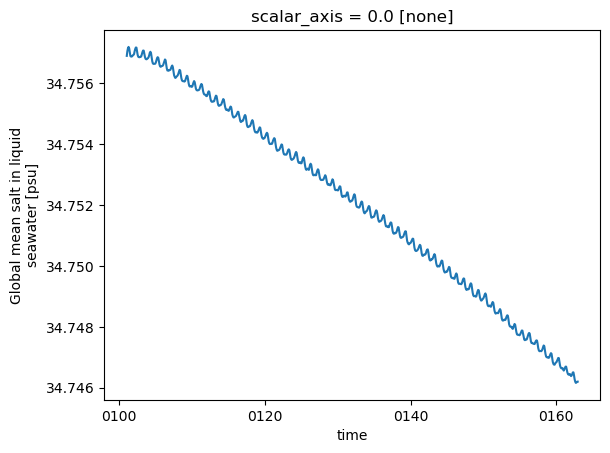

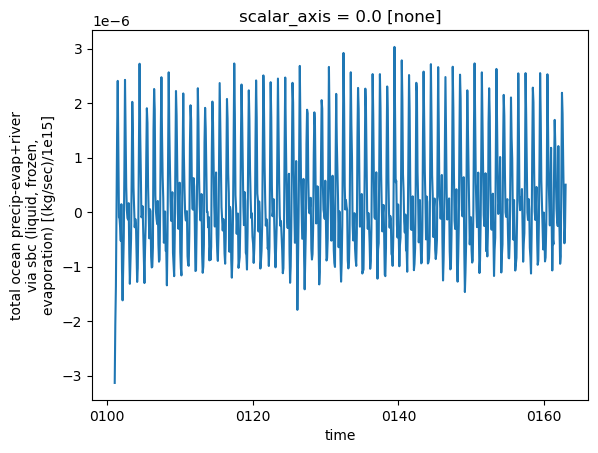

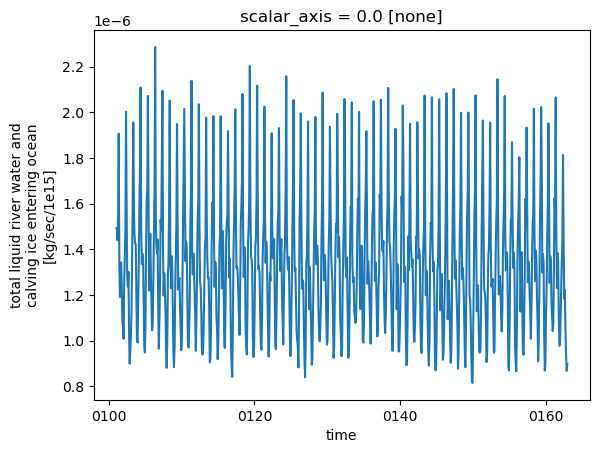

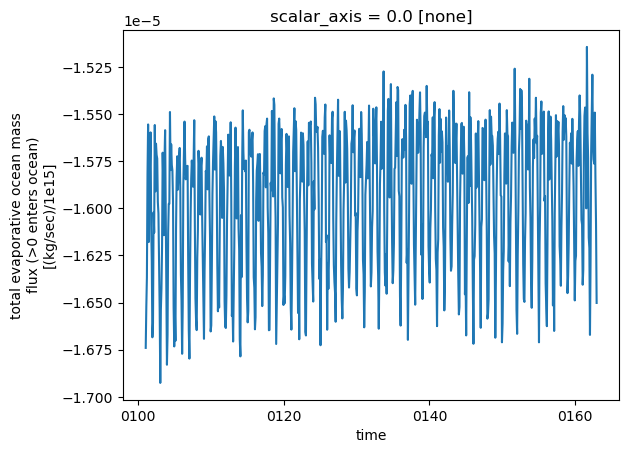

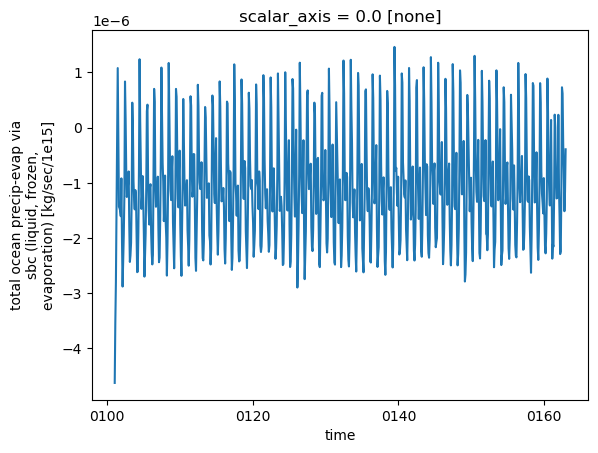

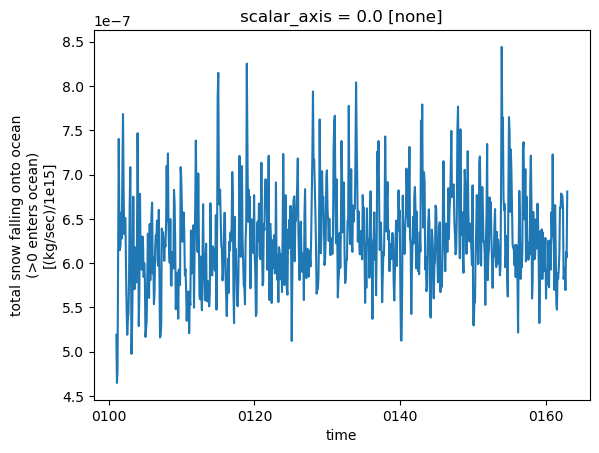

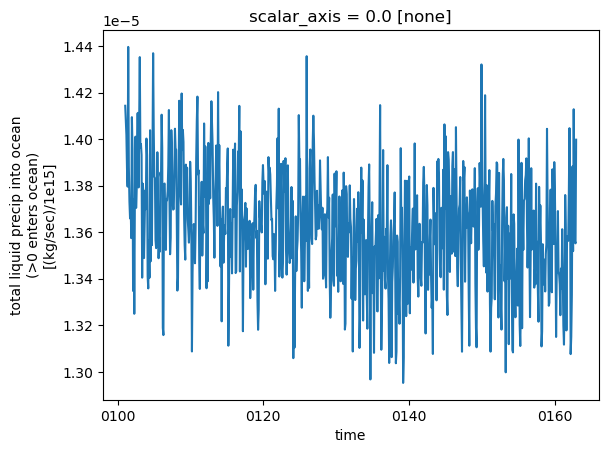

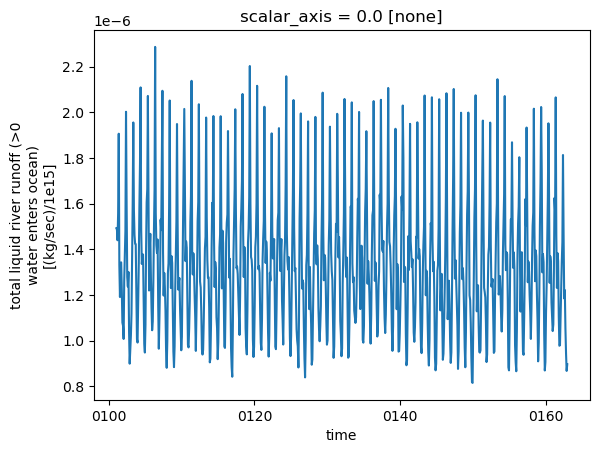

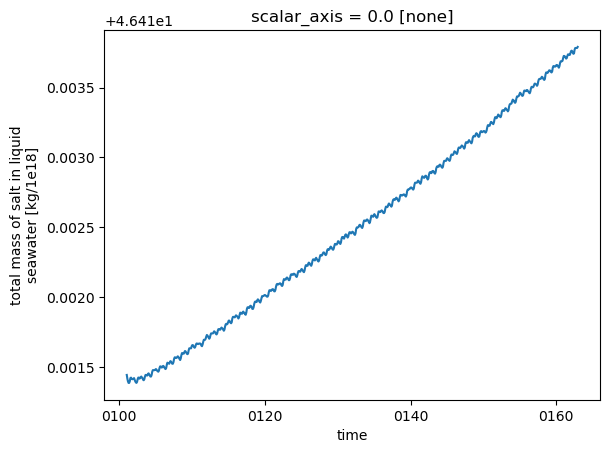

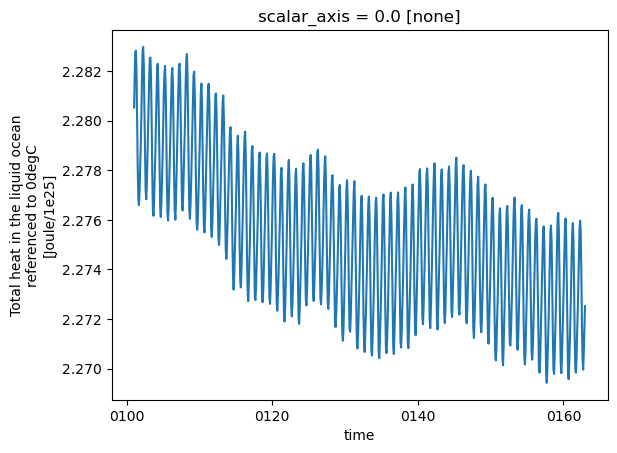

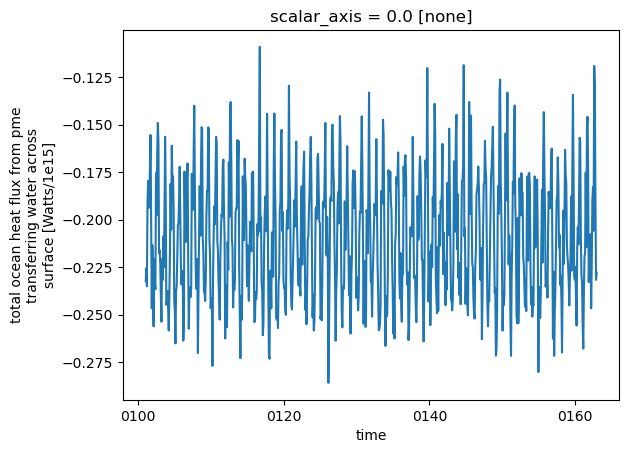

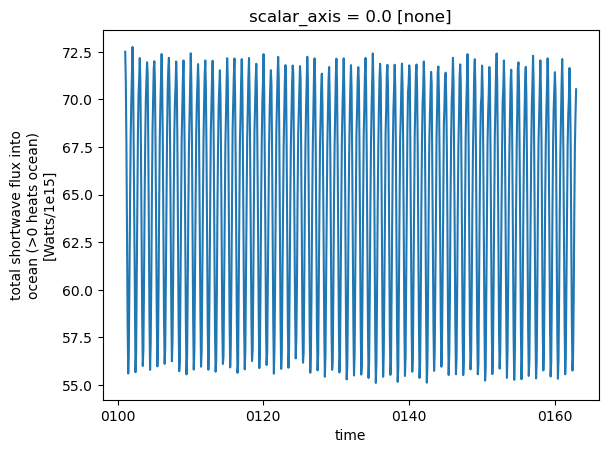

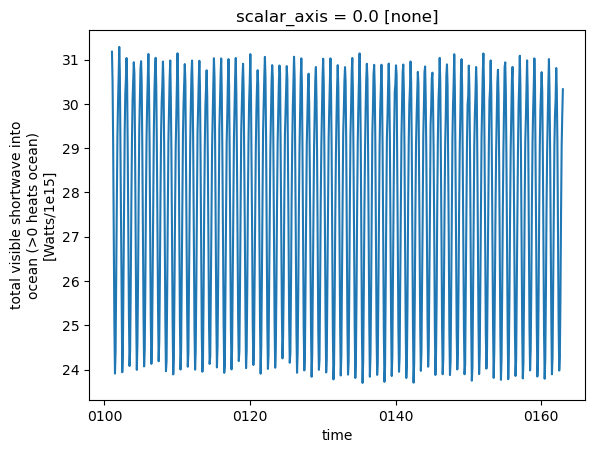

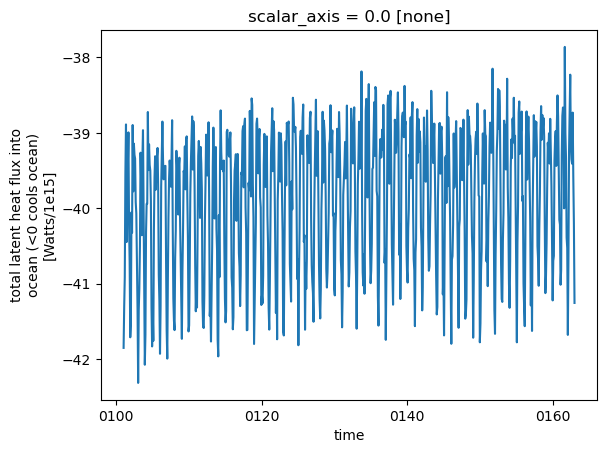

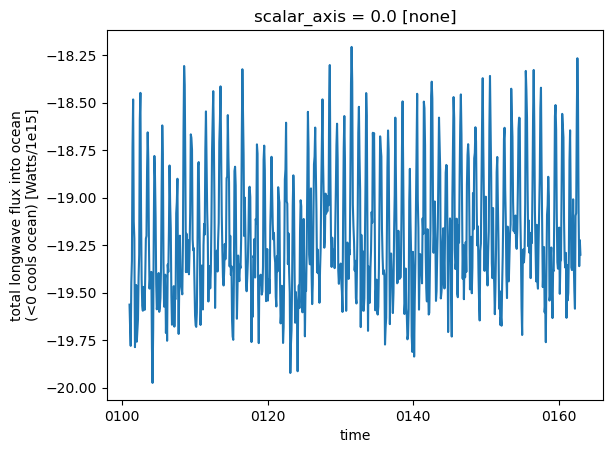

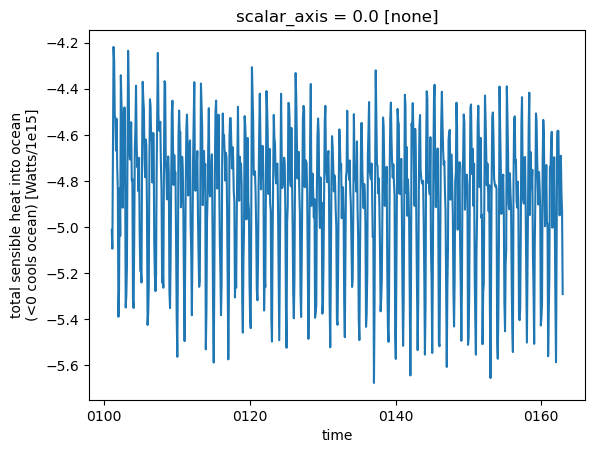

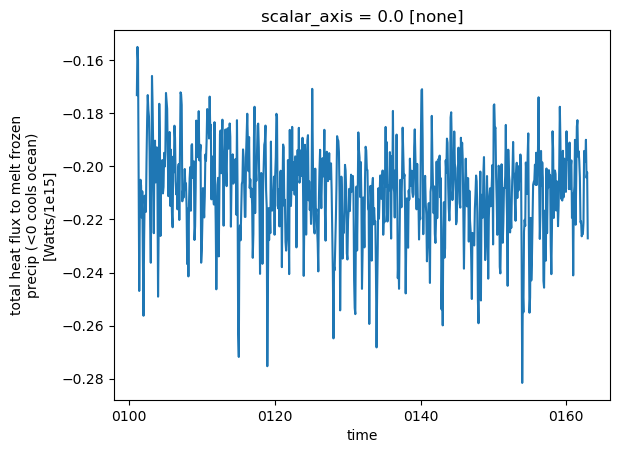

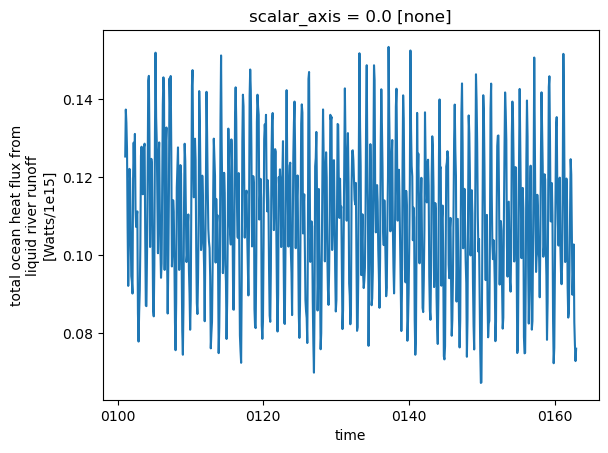

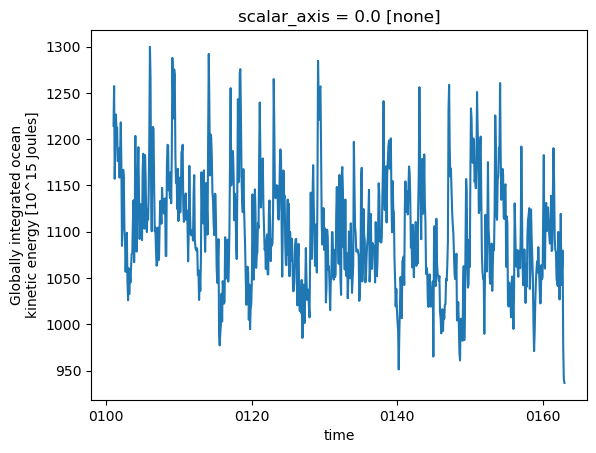

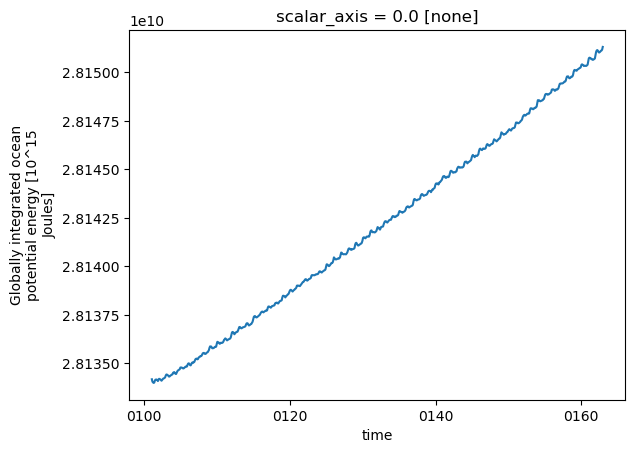

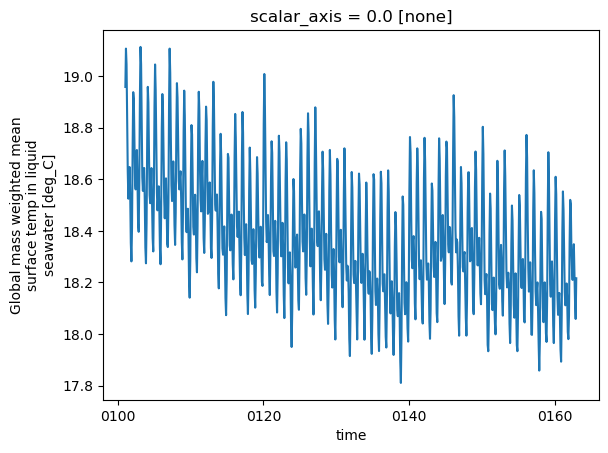

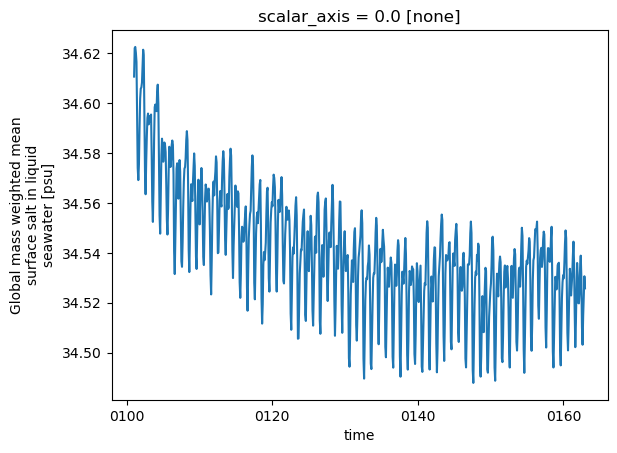

In [17]:
for iVar in list(ocn_scalar_ds.data_vars)[0:-4]:
    ocn_scalar_ds[iVar].plot()
    plt.show()

In [69]:
sfc_salt_flux_c5=ds = xr.open_mfdataset('/g/data/tm70/as2285/payu/esm1.6-preind+c-cice5+lprec0/archive/output0*/ocean/ocean-2d-sfc_salt_flux_ice-1monthly-mean-*')

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [71]:
sfc_salt_flux_ds = xr.open_mfdataset('/g/data/tm70/as2285/payu/esm1.6-preind-cice4/archive/output0*/ocean/ocean-2d-sfc_salt_flux_ice-1monthly-mean-ym_01*')

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

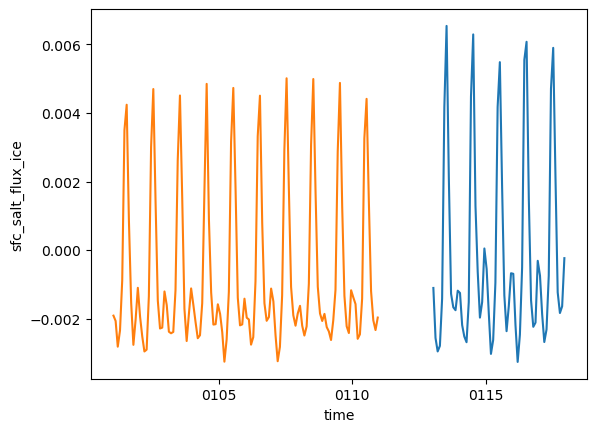

In [75]:
sfc_salt_flux_c5.sfc_salt_flux_ice.sum(['yt_ocean','xt_ocean']).plot()
sfc_salt_flux_ds.sfc_salt_flux_ice.sum(['yt_ocean','xt_ocean']).plot()

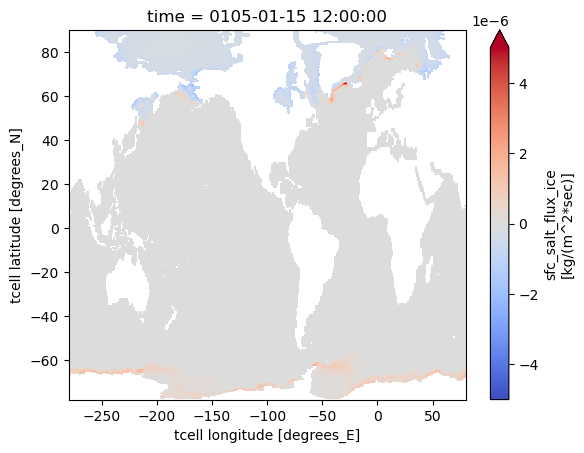

In [64]:
sfc_salt_flux_ds.sfc_salt_flux_ice.isel(time=0).plot(vmin=-5e-6, vmax=5e-6, cmap='coolwarm')

In [47]:
om3_salt_flux = xr.open_dataset('/g/data/tm70/as2285/payu/025_cgrid_1080_dt2/archive/output002/access-om3.mom6.2d.salt_flux_in.1mon.mean._1902.nc')

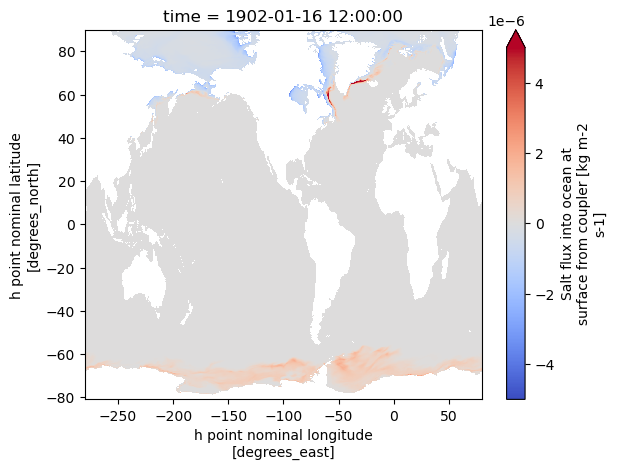

In [61]:
om3_salt_flux.salt_flux_in.isel(time=0).plot(vmin=-5e-6, vmax=5e-6, cmap='coolwarm')